In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../src'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/home/enis/projects/nna/src


In [2]:
import csv 
from pathlib import Path
from os import listdir
import pickle

from labeling_utils import load_labels

import numpy as np
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import train_test_split
import pandas as pd

tags=["Songbird","Water Bird","Insect","Running Water","Rain","Cable","Wind","Aircraft"]

from tabulate import tabulate
tag_set=tags[:]
import torch

%matplotlib inline

* Count only highest ranking tag (what if both of them exist)
* Bird tag is confusing, it can be also waterbird, how to handle ? Also Animal
* 

In [3]:
#LOAD MODEL predictions
splits_path= Path('/files/scratch/enis/data/nna/labeling/splits/')



In [4]:
import csv
from os import listdir
from pathlib import Path

# LOAD LABELS by human
labelsbyhumanpath=Path('/scratch/enis/data/nna/labeling/results/')
# filter csv extension also by username
labelsbyhuman=[i for i in listdir(labelsbyhumanpath) if (".csv" in i ) ]

humanresults={}
counter=0
for apath in labelsbyhuman:
    with open(labelsbyhumanpath / apath, newline='') as f:
        reader=csv.reader(f)
        for row in reader:
            counter+=1
            humanresults[row[0]]=row[1:]

print("unique files:",len(humanresults),"\ntotal files",counter)

#Join vehicle and Aircraft
for file_name,tagshere in humanresults.items():
#     print(file_name,tagshere)
    
    tagshere=["Aircraft" if tag == "Vehicle" else tag for tag in tags]

unique files: 1300 
total files 1366


In [5]:
# load name of the labels
labels=load_labels()

In [6]:
# returns a dictionary, keys are tags from tag set and values are binary list 
# 
def vectorized_y_true(humanresults,tag_set):
    y_true={tag: np.zeros(len(humanresults)) for tag in tag_set}
    for i,tags in enumerate(humanresults.values()):
        # we  only look for tags in tag_set
        for tag in tag_set:
            if tag in tags:
                y_true[tag][i] = 1
            else:
                y_true[tag][i] = 0 
    return y_true



In [7]:
y_true_dict = vectorized_y_true(humanresults,tags)
y_true_all = pd.DataFrame(y_true_dict)
y_true = np.array(y_true_all["Songbird"]).astype("long")


In [8]:
def map_reduce(X,func_type):
    if func_type=="Average":
        return np.mean(X,axis=1)
    elif func_type=="Concat":
        return np.reshape(X,(-1,1280))
    else:
        raise Exception("ERROR with embed type")

def pick_embed(embed_type):
    # humanresults[proc_embeds[0].replace("_embed.npy",".mp3")]
    X= np.empty((len(humanresults),10,128))
    for index,i in enumerate(humanresults):
        if embed_type=="Raw":
            file_name=i.replace(".mp3","_rawembed.npy")
        elif embed_type=="Normalized":
            file_name=i.replace(".mp3","_embed.npy")
        else:
            raise Exception("ERROR with embed type")
        an_x=np.load(split_path / file_name)
#         print(index,an_x)
        X[index,:,:]=an_x[:]
    return X

In [9]:

split_path=Path('/scratch/enis/data/nna/labeling/split_embeddings/')
# filter by username
split_embeds=[i for i in listdir(split_path) ]
raw_embeds =  [i for i in split_embeds if "rawembed" in i]
proc_embeds = [i for i in split_embeds if "_embed" in i]

In [10]:
X=pick_embed("Raw")
# X=map_reduce(X,map_reduce_type)
humanresults_keys=list(humanresults.keys())


In [11]:
X=X.astype("float32")

In [12]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
def cal_metrics(y_true_dict,y_pred_dict):
    results={}
    for tag in tag_set:
        y_true = y_true_dict[tag]
        y_pred = y_pred_dict[tag]
        metrics=precision_recall_fscore_support(y_true, y_pred,pos_label=1,average="binary")
        results[tag]=(metrics)
    return results

def cal_auc(y_true_dict,y_pred_dict_prob):
    results={}
    for tag in tag_set:
        y_true = y_true_dict[tag]
        y_pred = y_pred_dict_prob[tag]
        metrics_auc=roc_auc_score(y_true, y_pred) #average_precision_score
        results[tag]=(metrics_auc)

    return results

def print_results(results,y_true_dict,):
    headers= ["Label","Positive","Precision","Recall","Fscore"]
    table=[]
    sample_count=len(next(iter(y_true_dict.values())))
    print("Total sample:",sample_count,"And threshold is",prob_threshold)
    for tag in (tag_set):
        positive_count=sum(y_true_dict[tag])
        table.append([tag,positive_count,*results[tag][:-1]])

    print(tabulate(table, headers=headers))

    

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"

In [14]:
X_mean=X.mean(axis=1)


In [15]:
X.shape

(1300, 10, 128)

In [291]:
X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],-1), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

X_train=X_train.reshape(X_train.shape[0],-1,128)
X_test=X_test.reshape(X_test.shape[0],-1,128)
X_val=X_val.reshape(X_test.shape[0],-1,128)


In [292]:
# MEAN
X_train, X_test, y_train, y_test = train_test_split(
    X_mean, y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# X_train=X_train.reshape(X_train.shape[0],-1,128)
# X_test=X_test.reshape(X_test.shape[0],-1,128)
# X_val=X_val.reshape(X_test.shape[0],-1,128)


In [547]:
a=np.concatenate((np.array([1,2,3,4]),np.array([1,2,3,4])))
# for i in a:
#     np.array()


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [16]:
# seperate,  
# NEED TO CHANGE AUC calculation PART, to be fair  (do max of 10 predictions)
MULTI_SEGMENT = True
X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],-1), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# use 1 second as  samples
X_train=X_train.reshape(-1,128)
X_test=X_test.reshape(-1,128)
X_val=X_val.reshape(-1,128)

# repeat labels
y_train=np.repeat(y_train,10)
y_test=np.repeat(y_test,10)
y_val=np.repeat(y_val,10)


In [17]:
X_train=torch.from_numpy(X_train).to(device)
X_test=torch.from_numpy(X_test).to(device)
X_val=torch.from_numpy(X_val).to(device)

In [18]:
# birds

y_val=torch.from_numpy(y_val).to(device)
y_test=torch.from_numpy(y_test).to(device)
y_train=torch.from_numpy(y_train).to(device)


In [19]:
from torch.utils.data import Dataset, DataLoader


In [20]:
class audioDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,X,y, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X=X
        self.y=y
#         self.landmarks_frame = pd.read_csv(csv_file)
#         self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):

        sample = self.X[idx],self.y[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [21]:
params = {'batch_size': 200,
          'shuffle': True,
          'num_workers': 0}

training_set=audioDataset(X_train,y_train)
training_generator = DataLoader(training_set, **params)


In [131]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(128, 32)
        torch.nn.init.xavier_normal_(self.fc1.weight)

        self.fc2 = nn.Linear(32, 32)
        self.fc2_bn = nn.BatchNorm1d(32)

        self.fc3 = nn.Linear(32,32)
        self.fc3_bn = nn.BatchNorm1d(32)

        self.fc4 = nn.Linear(32, 2)
        torch.nn.init.xavier_normal_(self.fc4.weight)

        self.drop = nn.Dropout(p=0.2)
 
    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,128)
    
        x = F.relu(self.fc1(x))
        x=self.drop(x)

        x = F.relu(self.fc2_bn(x))
        x=self.drop(x)
        
        x = F.relu(self.fc3(x))
        x=self.drop(x)
#         x = F.relu(self.fc3(x))
#         x=self.drop(x)
#         x = F.relu(self.fc3(x))
#         x=self.drop(x)
#         x = F.relu(self.fc3_bn(x))
#         x=self.drop(x)

        x = self.fc4(x)
#         print(x)
        x = F.log_softmax(x,dim=1)
#         print(x)
        return x


net = Net().to(device)
loss_values={"test":[],"train":[],"train_auc":[],"test_auc":[]}


In [132]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(),weight_decay=0.01)

In [133]:
from IPython import display
import time
for epoch in range(2000):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(training_generator, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         print(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
#         running_loss += loss.item()
#     if epoch % 20 == 0:    # print every 2000 mini-batches

    test_loss,test_auc=nogradmetrics(X_test,y_test,net,multi_segment=MULTI_SEGMENT)
    train_loss,train_auc=nogradmetrics(X_train,y_train,net)

    loss_values["test"].append(test_loss)
    loss_values["train"].append(train_loss)
    loss_values["test_auc"].append(test_auc)
    loss_values["train_auc"].append(train_auc)
    if epoch % 20 == 0:    # print every 2000 mini-batches
        print('[%d] test : %.3f train: %.3f  test auc%.3f  train auc%.3f' %
              (epoch ,test_loss, train_loss,test_auc,train_auc))
        
        
#         display.clear_output(wait=True)
#         display.display(results.plot())
print('Finished Training')



[0] test : 0.668 train: 0.604  test auc0.678  train auc0.645
[20] test : 0.635 train: 0.487  test auc0.832  train auc0.797
[40] test : 0.620 train: 0.458  test auc0.836  train auc0.826
[60] test : 0.641 train: 0.457  test auc0.835  train auc0.828
[80] test : 0.716 train: 0.447  test auc0.802  train auc0.832
[100] test : 0.651 train: 0.440  test auc0.853  train auc0.840
[120] test : 0.684 train: 0.436  test auc0.828  train auc0.847
[140] test : 0.751 train: 0.436  test auc0.825  train auc0.844
[160] test : 0.773 train: 0.432  test auc0.804  train auc0.849
[180] test : 0.773 train: 0.432  test auc0.788  train auc0.846
[200] test : 0.743 train: 0.424  test auc0.824  train auc0.857
[220] test : 0.766 train: 0.427  test auc0.824  train auc0.853
[240] test : 0.799 train: 0.421  test auc0.811  train auc0.856
[260] test : 0.698 train: 0.419  test auc0.814  train auc0.862
[280] test : 0.685 train: 0.419  test auc0.811  train auc0.861
[300] test : 0.815 train: 0.418  test auc0.798  train auc0.85

KeyboardInterrupt: 

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd1c929d278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1da2240f0>)

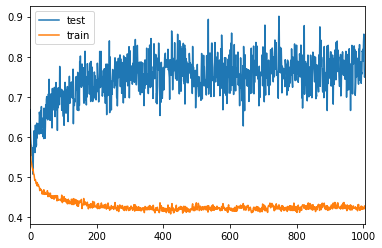

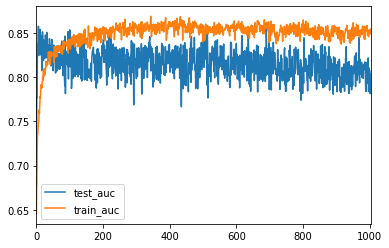

In [134]:
results=pd.DataFrame(loss_values)
results[["test","train"]].plot(),results[["test_auc","train_auc"]].plot(),

torch.Size([7800, 128])

In [ ]:
test_set=audioDataset(X_test,y_test)
test_generator = DataLoader(test_set, **params)


In [130]:
def nogradloss(X_test,y_test):
    with torch.no_grad():    
        outputs_test = net(X_test)
        loss = criterion(outputs_test, y_test)
        return loss.item()

def nogradmetrics(X_test,y_test,net,multi_segment=False):
    with torch.no_grad():    
        if not multi_segment:
            y_pred = net(X_test)
#             print(y_pred.shape)
#             print(y_pred[1:5,:])
    #         print(y_pred)
            loss = criterion(y_pred, y_test)
    #         print(y_pred)
            y_pred=torch.exp(y_pred)

    #         _, predicted = torch.min(y_pred,1)
    #         print(np.exp(_.cpu().numpy()),predicted)
            #         print(y_test.shape,y_pred.shape)
            train_auc=roc_auc_score(y_test.cpu().numpy(),
                                    y_pred[:,1].cpu().numpy()) 
        
            return loss.item(),train_auc
        else:
            y_pred = net(X_test)
            
            y_pred_10 =y_pred.reshape(-1,10,2)
            indices=torch.max(y_pred[:,1].reshape(-1,10),dim=1).indices
            y_pred_10 = y_pred_10[range(y_pred_10.shape[0]),indices,:].reshape(-1,2)
            
            y_test_10 = torch.max(y_test.reshape(-1,10),dim=1).values
            
            loss = criterion(y_pred_10, y_test_10)
            train_auc=roc_auc_score(y_test_10.cpu().numpy(),
                                    y_pred_10[:,1].cpu().numpy()) 
            return loss.item(),train_auc
            

In [121]:
# torch.randn(4,3,2)

In [116]:
# y_pred= torch.randn(20,2)
# print(y_pred)
# print(y_pred,y_pred[2:5,:])
# print(y_pred.shape)
y_pred_10=y_pred.reshape(-1,10,2)
# print(y_pred_10)
# print(y_pred_10.shape)
# print(y_pred_10[:,1])
# print(y_pred[:,1].reshape(-1,10))
# print(torch.max(y_pred[:,1].reshape(-1,10),dim=1).indices)
# print(y_pred_10[0,3,:])
# print(y_pred_10[1,4,:])
# print(y_pred_10[[0,1],[3,4],:])
indices=torch.max(y_pred[:,1].reshape(-1,10),dim=1).indices
y_pred_10[range(y_pred_10.shape[0]),indices,:].reshape(-1,2)



tensor([3, 4])
tensor([-0.2029,  1.7439])
tensor([-0.0895,  1.8500])
tensor([[-0.2029,  1.7439],
        [-0.0895,  1.8500]])


tensor([[-0.2029,  1.7439],
        [-0.0895,  1.8500]])

In [124]:
# b = torch.randn(2,10,100)
# print(b)
# torch.max(b,dim=2).indices.shape


In [127]:
nogradmetrics(X_test,y_test,net,multi_segment=True)


(1.2251720428466797, 0.46354166666666663)

In [612]:
with torch.no_grad():    

    y_pred = net(X_test)
    y_pred=torch.exp(y_pred)
    _, predicted = torch.max(y_pred,1)
    train_auc=roc_auc_score(y_test.cpu().numpy(),
                                    _.cpu().numpy())
    print(train_auc)
# # F.softmax(y_pred,dim=1)
# for i,val in enumerate(torch.exp(y_pred)):
#     print(i,val,y_test[i],predicted[i])

tensor([0.4380, 0.4380, 0.4380,  ..., 0.4380, 0.4380, 0.4380], device='cuda:0') tensor([[0.5620, 0.4380],
        [0.5620, 0.4380],
        [0.5620, 0.4380],
        ...,
        [0.5620, 0.4380],
        [0.5620, 0.4380],
        [0.5620, 0.4380]], device='cuda:0')
0.42527246605886293


In [411]:
np.exp([-6.7866, -4.4634])
F.softmax(torch.Tensor([0.5403, 0.4597]),dim=0),torch.exp(F.log_softmax(torch.Tensor([ 0.1147, -0.0307]),dim=0))

(tensor([0.5201, 0.4799]), tensor([0.5363, 0.4637]))

In [41]:
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
y_pred=torch.empty((0),dtype=torch.long).to(device)
with torch.no_grad():
    for data in training_generator:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
        y_pred=torch.cat((y_pred,predicted))

metrics_auc=roc_auc_score(y_train.cpu().numpy(), y_pred.cpu().numpy()) #average_precision_score
print(metrics_auc)

1.0


In [338]:
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
y_pred=torch.empty((0),dtype=torch.long).to(device)
with torch.no_grad():
    for data in test_generator:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
        y_pred=torch.cat((y_pred,predicted))
    
metrics_auc=roc_auc_score(y_test.cpu().numpy(), y_pred.cpu().numpy()) #average_precision_score
print(metrics_auc)

0.4991883116883116


tensor([0.7311, 0.2689])

(tensor([0.7311, 0.2689]), tensor([0.2689, 0.7311]))

In [130]:
# ALL  DATA
results=cal_auc(y_true_dict,y_pred_dict_prob)
print("ALL DATA")
for res in results:
    print("{} {:.2}".format(res,results[res]))
# print_results(results,y_true_dict)

{'Songbird': 0.7082863407231784, 'Water Bird': 0.6006567028985507, 'Insect': 0.6834210526315789, 'Running Water': 0.5683573612931411, 'Rain': 0.44851713640381025, 'Cable': 0.6487356572711399, 'Wind': 0.6398137867851588, 'Aircraft': 0.4890358265947889}


In [135]:
# VALIDATION SET
results=cal_auc(y_val_dict,y_val_pred_dict)
print("VALIDATION SET")
for res in results:
    print("{} {:.2}".format(res,results[res]))
# print(results)

VALIDATION SET
Songbird 0.68
Water Bird 0.58
Insect 0.7
Running Water 0.55
Rain 0.46
Cable 0.67
Wind 0.65
Aircraft 0.44


In [143]:
# Test SET
results=cal_auc(y_test_dict,y_test_pred_dict)
print("Test SET")
for res in results:
    print("{} {:.2}".format(res,results[res]))
# print(results)


Test SET
Songbird 0.7
Water Bird 0.59
Insect 0.66
Running Water 0.57
Rain 0.44
Cable 0.65
Wind 0.66
Aircraft 0.52


In [142]:
print("tag","train","validate","test")
table=[]
headers=["tag","train","validate","test"]
# for i in sorted_result:
#     if i[0] in tag2labelmappings[tag]:
#         table.append([i[0][0:10],i[1],"yes"])
#     else:
#         table.append([i[0][0:10],i[1],"no"])
    

for tagname in y_train_dict:
    table.append([tagname,sum(y_train_dict[tagname]),sum(y_test_dict[tagname]),sum(y_val_dict[tagname])])
print(tabulate(table, headers=headers))  


tag train validate test
tag              train    validate    test
-------------  -------  ----------  ------
Songbird           252          84      73
Water Bird         108          46      42
Insect             107          42      41
Running Water      130          41      39
Rain                62          20      20
Cable              278          93      85
Wind               386         123     132
Aircraft            18           6       4


#### Creating AUC matrix for each tag and label

In [107]:
# get all labels that exists in data to create matrix, if it is higher than 0 at least once
index_set=set()
for orig,audioop in modelresults.values():
#     print(orig)
    for index,prob in zip(*orig):
        if prob>0:
            index_set.add(index)

print("number of unique labels in the data",len(index_set))
index_set=list(index_set)


number of unique labels in the data 222


In [108]:
# ALL DATA
matrix_dict={}
for label_index in index_set:
    prob_threshold=0
    y_pred_dict=vectorized_y_pred_prob_pertag(label_index,humanresults,tags,label2tagmappings,prob_threshold)
    
#     y_train_pred_dict = {}
#     y_test_pred_dict ={}
#     y_val_pred_dict={}

#     for y in y_true_dict.keys():
#         y_pred=y_pred_dict[y]

#         y_train_pred_dict[y] = y_pred[y_train]
#         y_test_pred_dict[y] =y_pred[y_test]
#         y_val_pred_dict[y]=y_pred[y_val]
    
    matrix_dict[label_index]=y_pred_dict

In [109]:
# TRAIN DATA
matrix_dict={}
for label_index in index_set:
    prob_threshold=0
    y_pred_dict=vectorized_y_pred_prob_pertag(label_index,humanresults,tags,label2tagmappings,prob_threshold)
    
    y_train_pred_dict = {}
#     y_test_pred_dict ={}
#     y_val_pred_dict={}

    for y in y_true_dict.keys():
        y_pred=y_pred_dict[y]

        y_train_pred_dict[y] = y_pred[y_train]
#         y_test_pred_dict[y] =y_pred[y_test]
#         y_val_pred_dict[y]=y_pred[y_val]
    
    matrix_dict[label_index]=y_train_pred_dict

results={}
for label_index in index_set:
    results[label_index]=cal_auc(y_train_dict,matrix_dict[label_index])



In [110]:
# VAL DATA
matrix_dict={}
for label_index in index_set:
    prob_threshold=0
    y_pred_dict=vectorized_y_pred_prob_pertag(label_index,humanresults,tags,label2tagmappings,prob_threshold)
    
#     y_train_pred_dict = {}
#     y_test_pred_dict ={}
    y_val_pred_dict={}

    for y in y_true_dict.keys():
        y_pred=y_pred_dict[y]

#         y_train_pred_dict[y] = y_pred[y_train]
#         y_test_pred_dict[y] =y_pred[y_test]
        y_val_pred_dict[y]=y_pred[y_val]
    
    matrix_dict[label_index]=y_val_pred_dict

results={}
for label_index in index_set:
    results[label_index]=cal_auc(y_val_dict,matrix_dict[label_index])



In [144]:
# Test DATA
matrix_dict={}
for label_index in index_set:
    prob_threshold=0
    y_pred_dict=vectorized_y_pred_prob_pertag(label_index,humanresults,tags,label2tagmappings,prob_threshold)
    
#     y_train_pred_dict = {}
    y_test_pred_dict ={}
#     y_val_pred_dict={}

    for y in y_true_dict.keys():
        y_pred=y_pred_dict[y]

#         y_train_pred_dict[y] = y_pred[y_train]
        y_test_pred_dict[y] =y_pred[y_test]
#         y_val_pred_dict[y]=y_pred[y_val]
    
    matrix_dict[label_index]=y_test_pred_dict

results={}
for label_index in index_set:
    results[label_index]=cal_auc(y_test_dict,matrix_dict[label_index])


In [40]:
# auc_values=[]
# for values in results.values():
# #     print(values['Songbird'])
#     auc_values.append(values['Songbird'])

In [145]:

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


In [146]:
auc_matrix=np.empty((len(results),len(tag_set)))

In [147]:
for row,result in enumerate(results.values()):
    for col,tag in enumerate(tag_set):
        auc_matrix[row][col]=result[tag]

results_labels = [labels[key] for key in results.keys()]


In [148]:
# x = np.array([[10,2,3],[3,4,5],[6,7,8],[3,4,5]])
# x

In [149]:
# rows=x.mean(axis=0)
# colums=x.mean(axis=1)
# rows,colums

In [150]:
# print(x)
# print(x[colums.argsort()])
# print(x[:,rows.argsort()])


In [151]:
# rows=auc_matrix.mean(axis=0)
# colums=auc_matrix.mean(axis=1)

# sorted_col=(auc_matrix[colums.argsort()])
# sorted_row=(auc_matrix[:,rows.argsort()])
# tag_set
# results_labels

In [177]:
import pandas as pd
results_labels_short=results_labels[:]
for i,name in enumerate(results_labels):
    limit=12
    if len(name)>limit:
        name=(name[:limit]+"+")
    else:
        name=(name)
    results_labels_short[i]=name
#     print(name)

df_auc=pd.DataFrame(data=auc_matrix,    # values
              index=results_labels_short,    # 1st column as index
              columns=tag_set)



print(df_auc)


               Songbird  Water Bird    Insect  Running Water      Rain  \
Speech         0.470407    0.515542  0.441022       0.440082  0.531250   
Noise          0.505276    0.554551  0.489406       0.504956  0.464583   
Environmenta+  0.500000    0.500000  0.500000       0.500000  0.500000   
Static         0.493168    0.446820  0.578910       0.468649  0.425417   
Mains hum      0.500000    0.500000  0.500000       0.500000  0.500000   
...                 ...         ...       ...            ...       ...   
Pulse          0.494521    0.501625  0.502621       0.488584  0.489583   
Inside, smal+  0.486303    0.494667  0.509393       0.481735  0.511146   
Outside, urb+  0.497531    0.504013  0.490826       0.490868  0.491667   
Outside, rur+  0.503145    0.508584  0.495413       0.495434  0.495833   
Reverberatio+  0.500000    0.500000  0.500000       0.500000  0.500000   

                  Cable      Wind  Aircraft  
Speech         0.538697  0.511364  0.425197  
Noise          0.51

In [178]:
# df_auc.to_pickle("./auc_matrix.pkl")


In [179]:
auc_matrix

array([[0.4704072 , 0.51554246, 0.44102228, ..., 0.5386968 , 0.51136431,
        0.42519685],
       [0.50527597, 0.554551  , 0.48940585, ..., 0.51535638, 0.4988428 ,
        0.54790026],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       ...,
       [0.49753111, 0.5040126 , 0.49082569, ..., 0.48802395, 0.51626016,
        0.49212598],
       [0.50314529, 0.50858391, 0.49541284, ..., 0.50235014, 0.50038573,
        0.49606299],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ]])

In [180]:
df_auc

,Songbird,Water Bird,Insect,Running Water,Rain,Cable,Wind,Aircraft
Speech,0.470407,0.515542,0.441022,0.440082,0.531250,0.538697,0.511364,0.425197
Noise,0.505276,0.554551,0.489406,0.504956,0.464583,0.515356,0.498843,0.547900
Environmenta+,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Static,0.493168,0.446820,0.578910,0.468649,0.425417,0.406188,0.443089,0.589239
Mains hum,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
...,...,...,...,...,...,...,...,...
Pulse,0.494521,0.501625,0.502621,0.488584,0.489583,0.501835,0.504955,0.574147
"Inside, smal+",0.486303,0.494667,0.509393,0.481735,0.511146,0.509851,0.494036,0.484252
"Outside, urb+",0.497531,0.504013,0.490826,0.490868,0.491667,0.488024,0.516260,0.492126
"Outside, rur+",0.503145,0.508584,0.495413,0.495434,0.495833,0.502350,0.500386,0.496063


In [181]:
df_auc.isna().sum()

Songbird         0
Water Bird       0
Insect           0
Running Water    0
Rain             0
Cable            0
Wind             0
Aircraft         0
dtype: int64

In [182]:
df_auc.mean(axis=1)

Speech           0.484195
Noise            0.510109
Environmenta+    0.500000
Static           0.481435
Mains hum        0.500000
                   ...   
Pulse            0.507234
Inside, smal+    0.496423
Outside, urb+    0.496414
Outside, rur+    0.499651
Reverberatio+    0.500000
Length: 222, dtype: float64

In [183]:
# sort_function=max

In [184]:
tag_df_auc=df_auc.reindex(df_auc.max().sort_values(ascending=False).index, axis=1)

In [185]:
label_df_auc=df_auc.reindex(df_auc.max(axis=1).sort_values(ascending=False).index, axis=0)

In [186]:
tag_label_df_auc=tag_df_auc.reindex(tag_df_auc.max(axis=1).sort_values(ascending=False).index, axis=0)

In [187]:
label_df_auc.isna().sum()

Songbird         0
Water Bird       0
Insect           0
Running Water    0
Rain             0
Cable            0
Wind             0
Aircraft         0
dtype: int64

In [188]:
tag_df_auc.isna().sum()

Aircraft         0
Rain             0
Wind             0
Cable            0
Water Bird       0
Songbird         0
Insect           0
Running Water    0
dtype: int64

In [189]:
tag_label_df_auc.isna().sum()

Aircraft         0
Rain             0
Wind             0
Cable            0
Water Bird       0
Songbird         0
Insect           0
Running Water    0
dtype: int64

In [190]:
# plt.figure(figsize=(12, 150))

# ax = sns.heatmap(auc_matrix,xticklabels=tag_set,yticklabels=results_labels,annot=True,linewidths=.5)


In [191]:
# plt.figure(figsize=(12, 150))

# ax_label_mean = sns.heatmap(label_df_auc,xticklabels=label_df_auc.columns,yticklabels=label_df_auc.index,annot=True,linewidths=.5)


In [192]:
# plt.figure(figsize=(12, 100))

# ax_tag_mean = sns.heatmap(tag_df_auc,xticklabels=tag_df_auc.columns,yticklabels=tag_df_auc.index,annot=True,linewidths=.5)


In [193]:
# fig=ax_label_mean.get_figure()
# fig.savefig("ax_label_mean.png")

In [194]:
# fig=ax_tag_mean.get_figure()
# fig.savefig("ax_tag_mean.png")

In [195]:
# fig, ax = plt.subplots(figsize=(200, 100))


# im, cbar = heatmap(auc_matrix, results_labels,tag_set, ax=ax,
#                    cmap="YlGn", cbarlabel="harvest [t/year]")
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")

# fig.tight_layout()
# plt.show()

In [196]:
# FILTER results
threshold=0.58
print(tag_label_df_auc[tag_label_df_auc.max(axis=1)>threshold].shape)
fg_df=tag_label_df_auc[tag_label_df_auc.max(axis=1)>threshold].T

(38, 8)


(8, 0)

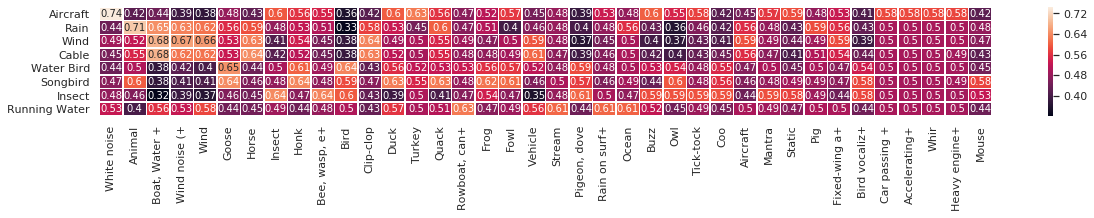

In [197]:

# plt.figure(figsize=(15, 2))

fig, ax = plt.subplots(figsize=(20,2))         # Sample figsize in inches

tag_label_max = sns.heatmap(fg_df,xticklabels=fg_df.columns,yticklabels=fg_df.index,annot=True,linewidths=.5)
ax.set_ylim(len(fg_df), 0)


In [198]:
fig=tag_label_max.get_figure()
fig.savefig("test_filter0.58_rotated_short.svg",bbox_inches="tight", format='svg')